In [1]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
resized_m, resized_n = 100, 100

# Load images
def load_image(image_path, new_m, new_n):
  """ (str, int, int) -> None
  This function is aimed to load and resize image
  """
  image = cv.imread(image_path)
  image = cv.resize(image, (new_m, new_n))
  cv2_imshow(image)
  return image

In [3]:
def image_to_vector(image_matrix, n, m):
  """(list, int, int) -> (list)
  Function is aimed to turn image matrix into a vector
  """
  image_vector = []
  for k in range(n): # columns
    for j in range(m): # rows
      image_vector.append(image_matrix[k][j][0])
  return image_vector

In [4]:
def out_of_focus_psf(k, l, r):
  """ (int, int, int) -> list
  This function is creating point spread function matrix to 
  make picture out focus
  """
  p = []
  for i in range(r):
    p_i = []
    for j in range(r):
      if (i-k)**2 + (j-l)**2 <= r**2:
        p_i.append(1/(math.pi * r**2))
      else:
        p_i.append(0)
    p.append(p_i)
  return p

In [5]:
def gaussian_psf(k, l, s1, s2):
  """(int, int, int, int) -> list
  This function is creating Gaussian point spread function matrix
  """
  p = []
  for i in range(s1):
    p_i = []
    for j in range(s2):
      entry = np.exp(-1/2*(((i-k)/s1)**2 + ((j-l)/s2)**2))
      p_i.append(entry)
    p.append(p_i)
  return p

In [6]:
def psf_to_vector(psf, n, m):
  """(list, int, int) -> list
  This function turns PSF matrix into vector
  """
  psf_vector = []
  for k in range(n): # columns
    for j in range(m): # rows
      psf_vector.append(psf[j][k])
  return psf_vector

In [7]:
def construct_blurring_matrix(psf_vector, m, n):
  """ (list, int, int) -> list
  This function creates a blurring matrix
  """
  A = []
  l = len(psf_vector)
  initial_index = l // 2 + 1

  # For every row
  for i in range(n):
      if initial_index < l:
          len_p = len(psf_vector[:initial_index])
          row = list(reversed(psf_vector[:initial_index])) + [0 for j in range(n - len_p)]
          A.append(row)
          initial_index += 1

      else:
          shift = abs(l - initial_index)
          len_p = len(psf_vector[:initial_index])
          row = [0 for j in range(shift)] + list(reversed(psf_vector[:initial_index])) \
                + [0 for j in range(n - len_p - shift)]
          A.append(row[:n])
          initial_index += 1

  return A

In [8]:
def vector_to_image(vector):
  """ (list) -> (list)
  This function converts vactor back to image
  """
  n = int(math.sqrt(len(vector)))
  image_matrix = []
  for i in range(n):
    row = []
    for j in range(i*n, (i+1)*n):
      entry = vector[j]
      row.append([entry for i in range(3)])
    image_matrix.append(row)
  return image_matrix

In [9]:
def blur_image(path, psf_array):
  """ (str, list) -> (list, list, list)
  """
  dot_image = load_image(path, resized_m, resized_n)
  x = image_to_vector(dot_image, resized_n, resized_m) # our original image
  
  blurring_matrix = construct_blurring_matrix(psf_array, resized_n**2, resized_m**2) # matrix A

  blurred_vector = [i for i in np.matmul(blurring_matrix, x)]
  blurred_image = vector_to_image(blurred_vector)
  return blurred_vector, blurred_image, blurring_matrix

In [10]:
def write_image(image, new_image_path, resized_m, resized_n):
  """ (list, str, int, int) -> None
  This function saves changed picture 
  """
  converted_image = cv.UMat(np.array(image, dtype=np.uint64))
  resized = cv.resize(converted_image, (resized_n, resized_m))
  cv.imwrite(new_image_path, resized)

In [11]:
def naive_deblur(blurring_image, blurred_vector):
  """ (list, list) -> (list)
  This function is deblurring image using naive method
  """
  blurring_inverse = np.linalg.inv(blurring_image)
  x = np.matmul(blurring_inverse, blurred_vector) # x - original image, x = A^(-1)*b
  x_matrix = vector_to_image(x)
  return x_matrix

In [ ]:
# Here you can use one of two different point spread functions and commenting
# the one you do not want to use

# out-of-focus
x_coordinate, y_coordinate, radius = 1, 1, 5
psf_matrix = out_of_focus_psf(x_coordinate, y_coordinate, radius)

# gaussian
# x_coordinate, y_coordinate, s1, s2 = 15, 15, 10, 10
# psf_matrix = gaussian_psf(x_coordinate, y_coordinate, s1, s2)

psf_array = psf_to_vector(psf_matrix, 5, 5) # our psf array

In [12]:
def reconstruct(k, A, b):
  """ (int, list, list) -> ndarray
  This function is reconstructing blurred picture using singular 
  value decomposition(SVD)
  """
  U, s, V = np.linalg.svd(A)
  A_inverse = np.matrix(U[:, :k]) * np.diag(1/s[:k]) * np.matrix(V[:k, :])
  return np.asarray(np.matmul(A_inverse, b))[0]
  


In [ ]:
def truncated_reconstruction(blurring_matrix, blurred_vector, k):
  """ (list, list, int) -> list
  This function is recinstructing image with truncated SVD
  """
  xk = reconstruct(k, blurring_matrix, blurred_vector)
  truncated = vector_to_image(xk)
  return truncated

In [ ]:
blurred_vector, blurred_daisy, blurring_matrix = blur_image('/root/daisy.jpg', psf_array)
write_image(blurred_daisy, '/root/blurred_daisy.jpg', resized_m, resized_n)

In [ ]:
k = 10000
truncated = truncated_reconstruction(blurring_matrix, blurred_vector, k)
write_image(truncated, '/root/truncated_restored_daisy.jpg', resized_m, resized_n)

In [ ]:
naive_daisy_deblur = naive_deblur(blurring_matrix, blurred_vector)
write_image(naive_daisy_deblur, '/root/naive_restored_daisy.jpg', resized_m, resized_n)

In [ ]:
def noise_vector(vector_):
  """ (list) -> (list)
  This function is adding noise to the image vector
  """
  n = len(vector_)
  e = np.random.normal(size=n)
  e = e/np.linalg.norm(e)
  vector_ = vector_ + np.linalg.norm(vector_)*e
  return vector_


In [ ]:
noised_vector = noise_vector(blurred_vector)
write_image(vector_to_image(noised_vector), '/root/noised_daisy.jpg', resized_m, resized_n)

In [ ]:
naive_noise_deblur_daisy = naive_deblur(blurring_matrix, noised_vector)
write_image(naive_noise_deblur_daisy, '/root/naive_noise_deblur_daisy.jpg', resized_m, resized_n)

In [ ]:
k = 8000
truncated_vector = reconstruct(k, blurring_matrix, noised_vector)
write_image(vector_to_image(truncated_vector), '/root/denoised_daisy.jpg', resized_m, resized_n)

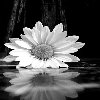

In [ ]:
resized = load_image('/root/daisy.jpg', resized_m, resized_n)
write_image(resized, '/root/resized_daisy.jpg', resized_m, resized_n)